In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import scipy.io
mat_dict = scipy.io.loadmat('StevensonV2.mat')

In [4]:
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

In [7]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handVel'][0,:]

In [8]:
nt, nneuron = X0.shape
print("num nt={0:d}  num nneuron={1:d}".format(nt,nneuron))

num nt=15536  num nneuron=196


In [9]:
ti=mat_dict['time'].T
t0=np.reshape(ti,15536)
t0.shape

(15536,)

In [10]:
tsamp=t0[np.array([1])]-t0[np.array([0])]
ttal=t0[np.array([nt-1])]-t0[np.array([0])]
print("The sampling time = %f" % tsamp)
print("The total recording time = %f" % ttal)

The sampling time = 0.050000
The total recording time = 776.750000


In [23]:
# Number of samples for training and test
ntr = nt // 2
nts = nt - ntr

# Training and test
xtr = X0[:ntr,:]
ytr = y0[:ntr]
xts = X0[nts:,:]
yts = y0[nts:]

In [24]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(xtr,ytr)
y_tr_pred = regr.predict(xtr)

RSS_tr = np.mean((y_tr_pred-ytr)**2)/(np.std(ytr)**2)
print("Normalized RSS of the train sample = {0:f}".format(RSS_tr))

Normalized RSS of the train sample = 0.468805


In [25]:
y_te_pred = regr.predict(xts)

RSS_ts = np.mean((y_te_pred-yts)**2)/(np.std(yts)**2)
print("Normalized RSS of the test sample = {0:f}".format(RSS_ts))

Normalized RSS of the test sample = 1889379842913849311232.000000


In [32]:
xm = np.mean(xtr, axis = 0)
ym = np.mean(ytr)
x1 = xtr-xm[None, :]
y1 = ytr -ym
print(y1.shape)

(7768,)


<Container object of 3 artists>

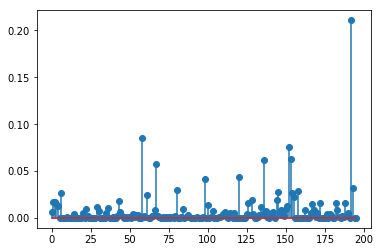

In [30]:
from sklearn.metrics import r2_score

regr = linear_model.LinearRegression()
k=np.arange(0,nneuron,1)
rsq = np.zeros(196)

for i in range (0, 195):
    x2 = X0[:,i]
    regr = regr.fit(x2[:,None],y0)
    y_pred = regr.predict(x2[:,None])
    rsq[i] = r2_score(y0, y_pred)

plt.stem(k,rsq)

In [25]:
d = 100
Isel = (-rsq).argsort()[:d]
print("The neurons with the ten highest R^2 values = ",Isel[:10])

The neurons with the ten highest R^2 values =  [192  58 152 153 136  67 120  98 193  80]


In [27]:
xnew = X0[:,Isel]

xtr = xnew[:ntr]
ytr = y0[:ntr]
xts = xnew[ntr:]
yts = y0[ntr:]

regr = linear_model.LinearRegression()
regr.fit(xtr,ytr)

y_tr_pred = regr.predict(xtr)
y_te_pred = regr.predict(xts)
RSS_tr = np.mean((y_tr_pred-ytr)**2)/(np.std(ytr)**2)
RSS_ts = np.mean((y_te_pred-yts)**2)/(np.std(yts)**2)
print("Normalized RSS of the train sample = {0:f}".format(RSS_tr))
print("Normalized RSS of the test sample = {0:f}".format(RSS_ts))

Normalized RSS of the train sample = 0.481172
Normalized RSS of the test sample = 0.497800


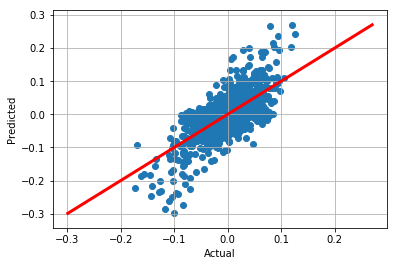

In [36]:
# Scatter plot
plt.scatter(y_te_pred, yts)
plt.xlabel('Actual')
plt.ylabel('Predicted')
ymin = np.min(yts)
ymax = np.max(yts)
plt.plot([ymin,ymax], [ymin,ymax], 'r-', linewidth=3)
plt.grid()
plt.show()

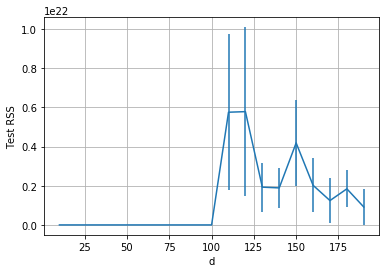

In [30]:
# k-fold cross validation
import  sklearn.model_selection 

nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)

# Loop over the folds
RSS_ts = np.zeros((nd,nfold),dtype=np.float_)

for isplit, Ind in enumerate(kf.split(xnew)):
        
    # Get the training data in the split
    Itr, Its = Ind
    xtr = X0[Itr]
    ytr = y0[Itr]
    xts = X0[Its]
    yts = y0[Its]
    
    for it, d in enumerate(dtest):
        xtr_2 = xtr[:,0:d]
        xts_2 = xts[:,0:d]
        regr = linear_model.LinearRegression()
        regr.fit(xtr_2,ytr)
        y_te_pred = regr.predict(xts_2)
        RSS_ts[it,isplit] = np.mean((y_te_pred-yts)**2)/(np.std(yts)**2)

RSS_mean = np.mean(RSS_ts,axis=1)
RSS_std  = np.std(RSS_ts,axis=1) / np.sqrt(nfold-1)

plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='-')
plt.xlabel('d')
plt.ylabel('Test RSS')
plt.grid()
plt.show()

The optimal model order is 100
RSS = 0.693421


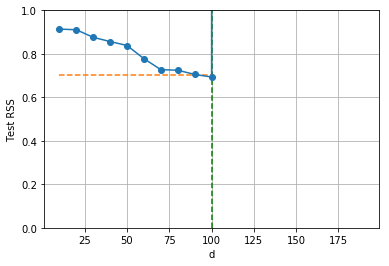

In [31]:
# Find the minimum RSS target
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]

# Find the lowest model order below the target
I = np.where(RSS_mean <= RSS_tgt)[0]
iopt = I[0]
dopt = dtest[iopt]

plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='o-')

# Plot the line at the RSS target
plt.plot([dtest[0],dtest[imin]], [RSS_tgt, RSS_tgt], '--')

# Plot the line at the optimal model order
plt.plot([dopt,dopt], [0,1], 'g--')

plt.ylim(0,1)
plt.xlabel('d')
plt.ylabel('Test RSS')
plt.grid()

print("The optimal model order is %d" % dopt)
print("RSS = %f" % RSS_mean[iopt])

In [32]:
#LASSO regression
from sklearn import linear_model, preprocessing

X = sklearn.preprocessing.scale(X0)
y = sklearn.preprocessing.scale(y0)

nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
model = linear_model.Lasso(warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-5,-1,nalpha)
RSS_ts = np.zeros((nalpha,nfold))

for ifold, ind in enumerate(kf.split(X0)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X0[Itr]
    y_tr = y0[Itr]
    X_ts = X0[Its]
    y_ts = y0[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        model.alpha = a
        model.fit(X_tr,y_tr)
        y_ts_pred = model.predict(X_ts)
        RSS_ts[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)

/Users/Forita/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


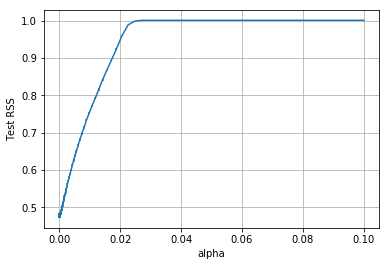

In [33]:
# Compute the mean and standard deviation over the different folds.
RSS_mean = np.mean(RSS_ts,axis=1)
RSS_std  = np.std(RSS_ts,axis=1) / np.sqrt(nfold-1)

plt.errorbar(alphas, RSS_mean, yerr=RSS_std, fmt='-')
plt.xlabel('alpha')
plt.ylabel('Test RSS')
plt.grid()
plt.show()

Optimal alpha = 0.000010
Mean RSS = 0.478143


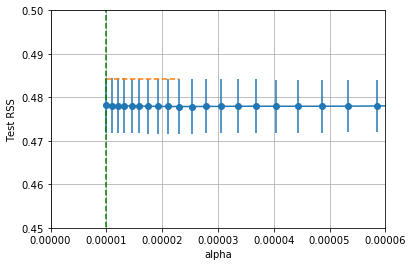

In [34]:
# Find the minimum RSS target
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]
alpha_min = alphas[imin]

# Find the lowest model order below the target
I = np.where(RSS_mean <= RSS_tgt)[0]
iopt = I[0]
alpha_opt = alphas[iopt]
RSS = RSS_mean[iopt]

plt.errorbar(alphas, RSS_mean, yerr=RSS_std, fmt='o-')

# Plot the line at the RSS target
plt.plot([alphas[0],alpha_min], [RSS_tgt, RSS_tgt], '--')

# Plot the line at the optimal model order
plt.plot([alpha_opt,alpha_opt], [0,0.5], 'g--')

plt.xlim(0,0.00006)
plt.ylim(0.45,0.5)
plt.xlabel('alpha')

plt.ylabel('Test RSS')
plt.grid()

# Print results
print("Optimal alpha = %f" % alpha_opt)
print("Mean RSS = %f" % RSS)

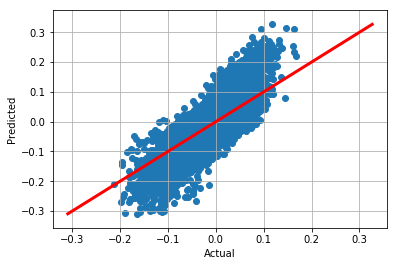

In [35]:
model.alpha = alpha_opt
model.fit(X0,y0)
y_pred = model.predict(X0)
RSS = np.mean((y_pred-y0)**2)/(np.std(y0)**2)

plt.scatter(y_pred, y0)
plt.xlabel('Actual')
plt.ylabel('Predicted')
ymin = np.min(y0)
ymax = np.max(y0)
plt.plot([ymin,ymax], [ymin,ymax], 'r-', linewidth=3)
plt.grid()
plt.show()